In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import pandas as pd

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver
from PDE_solver_backend_laplace import PDESolverLaplace
from random import shuffle

In [43]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def make_points_line(N,which_axis,fixed_value,range_other,nugget=1e-5):
    assert which_axis in {'x','y'}
    X=np.zeros((N,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=fixed_value
    X[:,1-num_axis]=np.linspace(range_other[0]+nugget,range_other[1]-nugget,N)
    return X

def make_points_on_specific_boundary(Nb,which_axis,which_side,range_model=np.array([-1,1])):
    assert which_axis in {'x','y'}
    assert which_side in {-1,1}
    assert range_model.shape==(2,) and range_model[1]-range_model[0]>=0
    X=np.zeros((Nb,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=which_side
    X[:,1-num_axis]=np.random.rand(Nb)*(range_model[1]-range_model[0])+range_model[0]
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

def laplacian_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model.laplacian(x[which_model==i])
    return res



In [44]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=exp(-x+y)*cos(pi*x*y)#cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)+u_symbolic**3
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2
#tau=lambda x:np.zeros_like(x)
#dtau=lambda x:np.zeros_like(x)
f_symbolic

-(-pi**2*x**2*cos(pi*x*y) - 2*pi*x*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) - (-pi**2*y**2*cos(pi*x*y) + 2*pi*y*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) + exp(-3*x + 3*y)*cos(pi*x*y)**3

In [45]:
int_point_number=18000
ext_point_number=9000
width=3
int_point_per_model=int_point_number//width**2
ext_point_per_model=ext_point_number//width**2

def make_models(int_point_per_model,ext_point_per_model,width,show=True):

    sigma=0.1
    boundary_width=0.0

    models=[]
    #laplace_models=[]
    for i in range(width**2):
        yi=i//width
        xi=i%width
        range_model=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        X_int=make_points_inside(int_point_per_model,range_model)
        X_bounds=[]
        if i%width==0:
            X_bounds.append(make_points_line(ext_point_per_model//4,'x',-1,[-1+2*yi/width,-1+2*(yi+1)/width]))
        if i%width==width-1:
            X_bounds.append(make_points_line(ext_point_per_model//4,'x',1,[-1+2*yi/width,-1+2*(yi+1)/width]))
        if i//width==0:
            X_bounds.append(make_points_line(ext_point_per_model//4,'y',-1,[-1+2*xi/width,-1+2*(xi+1)/width]))
        if i//width==width-1:
            X_bounds.append(make_points_line(ext_point_per_model//4,'y',1,[-1+2*xi/width,-1+2*(xi+1)/width]))
        if show:plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)

        try:
            X_boundary=np.concatenate(X_bounds)
            if show:plt.scatter(X_boundary[:,0],X_boundary[:,1],label=f'boundary {i}',s=5)
        except ValueError:
            X_boundary=np.empty((0,2))
        
        models.append(
            PDESolver(
                X_int=X_int,
                X_boundary=X_boundary,
                sigma=sigma,
                name=f'model {i}')
        )
        '''laplace_models.append(
            PDESolverLaplace(
                X_int=X_int,
                X_boundary=X_boundary,
                sigma=sigma,
                name=f'model laplace {i}')
        )'''
        if i%width>0:
            range_neighbors=np.array([
                [-1+2*xi/width-boundary_width,-1+2*xi/width+boundary_width],
                [-1+2*yi/width,-1+2*(yi+1)/width]
            ])
            #X_shared=make_points_line(ext_point_per_model//4,'x',-1+2*xi/width,[-1+2*yi/width,-1+2*(yi+1)/width])
            X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
            models[-1].add_neighbors([models[-2]], [X_shared])
            models[-2].add_neighbors([models[-1]], [X_shared])
            #laplace_models[-1].add_neighbors([laplace_models[-2]], [X_shared])
            #laplace_models[-2].add_neighbors([laplace_models[-1]], [X_shared])
            if show:plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
        if i//width>0:
            range_neighbors=np.array([
                [-1+2*xi/width,-1+2*(xi+1)/width],
                [-1+2*yi/width-boundary_width,-1+2*(yi)/width+boundary_width]
            ])
            X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
            #X_shared=make_points_line(ext_point_per_model//4,'y',-1+2*yi/width,[-1+2*xi/width,-1+2*(xi+1)/width])
            models[-1].add_neighbors([models[-1-width]], [X_shared])
            models[-1-width].add_neighbors([models[-1]], [X_shared])
            #laplace_models[-1].add_neighbors([laplace_models[-1-width]], [X_shared])
            #laplace_models[-1-width].add_neighbors([laplace_models[-1]], [X_shared])
            if show:plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

    if show:plt.show()
    return models

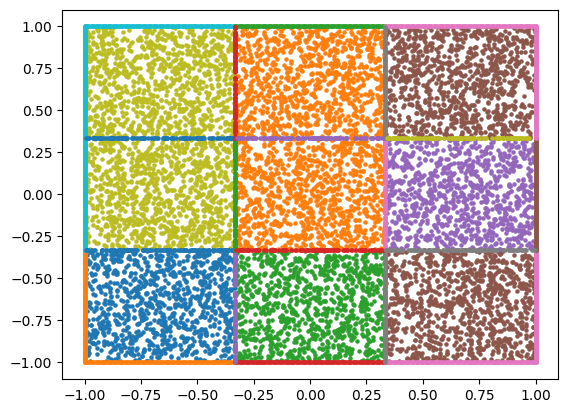

Current residual 3.587e-07: : 43it [03:18,  4.62s/it]


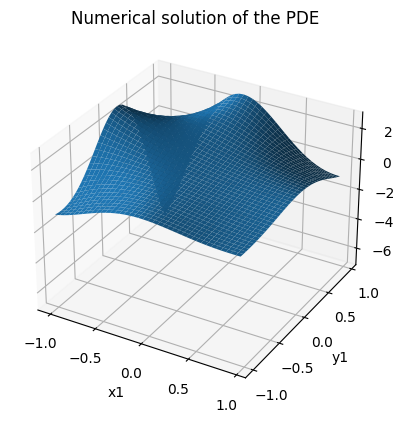

In [49]:
models=make_models(1000,500,3,show=True)
PDESolver.joint_fit(models,f,real_u,tau,dtau,tol=1e-6,nugget=1e-7)
aggregate=partial(dumb_aggregate,models=models,width=3)
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

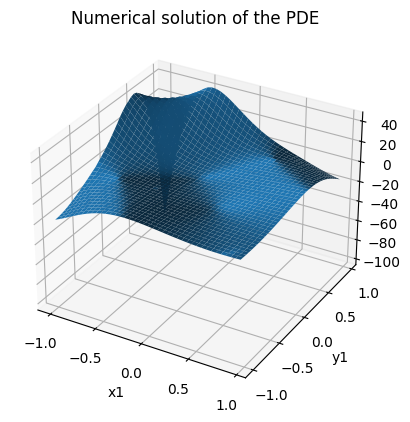

In [50]:
aggregate_lap=partial(laplacian_aggregate,models=models,width=3)
fig=plot_vectorized_function(aggregate_lap,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

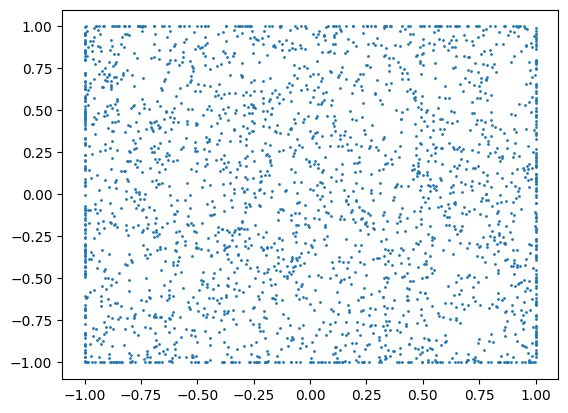

Current residual 9.170e-10: : 6it [00:18,  3.11s/it]


In [ ]:
model0=PDESolver(
        X_int=make_points_inside(2000),
        X_boundary=make_points_boundary(500),
        sigma=0.1,
        name=f'model 0')
plt.figure()
plt.scatter(model0.X_all[:,0],model0.X_all[:,1],s=1)
plt.show()
model0.fit_interior(f,real_u,tau,dtau,use_shared=False,share_laplacian=False,nugget=1e-7)
model0.a = np.concatenate(
    [
        model0.g_vec,
        model0.gauss_newton_solution["z"],
        model0.gauss_newton_solution["z_lap"],
    ]
)
model0.coeff = model0.K_inv @ model0.a

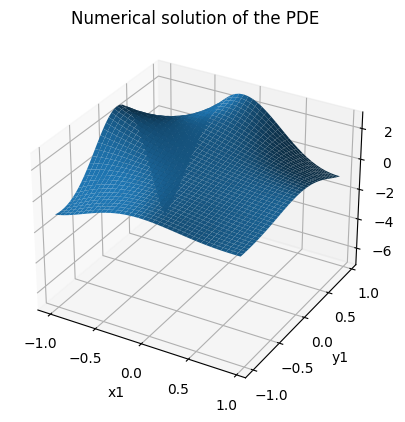

In [ ]:
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U0 = model0(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_indiv=models[0](np.stack([X.flatten(),Y.flatten()],axis=-1))
#U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
#U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))

In [ ]:
np.linalg.norm(U0-U_real,ord=np.inf)

0.0011865271856163068

In [ ]:
err_agg=np.linalg.norm(U_agg-U_real,ord=np.inf)
err_agg

0.011765714958131612

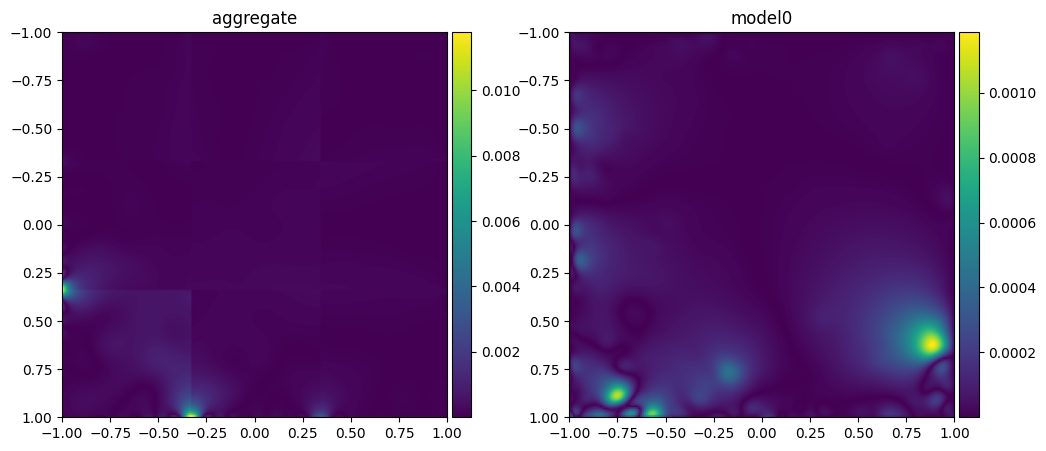

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
#axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('aggregate')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U0-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
#axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('model0')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

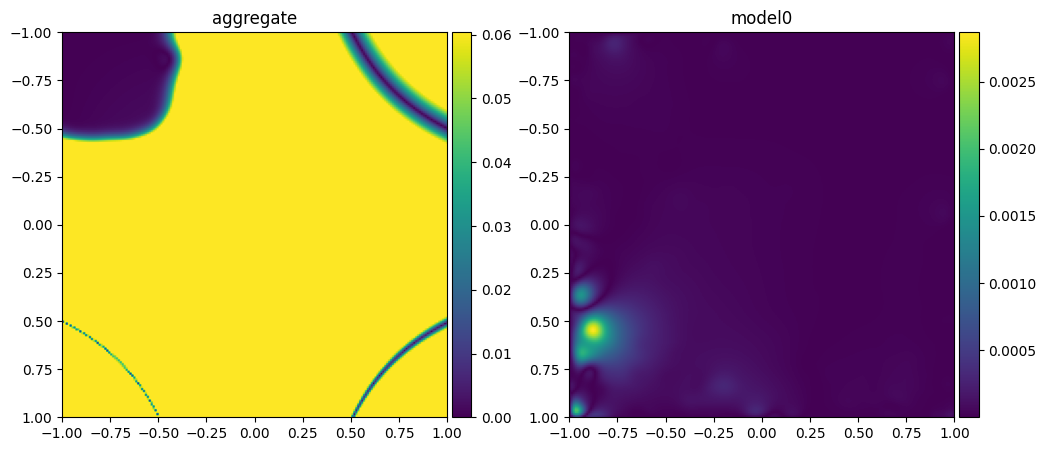

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.clip(np.abs(U_indiv-U_real),0,err_agg).reshape(X.shape),extent=[-1,1,1,-1])
#axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
#axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('aggregate')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U0-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
#axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('model0')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [ ]:
print(1/0)

ZeroDivisionError: division by zero

# Benchmarking

In [ ]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])

In [ ]:


already_done=pd.read_csv('benchmark.csv')
res={'width':[],'ratio':[],'points_per_model':[],'error mean':[],'error std':[],'error geo mean':[],'error geo std':[],'compute time mean':[],'compute time std':[]}
#k=0
for width in [10]:
    for ratio in [0.1,0.5,1,2]:
        for points_per_model in np.linspace(100,2000,10,dtype=np.int32):
            '''if k<len(already_done):
                 k+=1
                 continue'''
            print(width,ratio,points_per_model)
            times=[]
            errors=[]
            for tries in range(10):
                try:
                    models=make_models(points_per_model,int(ratio*points_per_model),width,show=False)
                    start_time = time.time()
                    PDESolver.joint_fit(models,f,real_u,tau,dtau,tol=1e-3,nugget=1e-7,show_progress=False)
                    solve_time=time.time() - start_time
                    aggregate=partial(dumb_aggregate,models=models,width=width)
                    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
                    errors.append(np.linalg.norm(U_real-U_agg,np.inf))
                    times.append(solve_time)
                except:
                    errors.append(np.nan)
                    times.append(np.nan)
            res['width'].append(width)
            res['ratio'].append(ratio)
            res['points_per_model'].append(points_per_model)
            res['error mean'].append(np.nanmean(errors))
            res['error std'].append(np.nanstd(errors))
            res['error geo mean'].append(np.exp(np.nanmean(np.log(errors))))
            res['error geo std'].append(np.exp(np.nanstd(np.log(errors))))
            res['compute time mean'].append(np.nanmean(times))
            res['compute time std'].append(np.nanstd(times))
            pd.concat([already_done,pd.DataFrame(res)]).to_csv('benchmark.csv',index=False)
            #k+=1

            
      

10 0.1 100


/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_15640/1131523265.py:15: RuntimeWarning: overflow encountered in power
  tau=lambda x:np.power(x,3)
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:204: RuntimeWarning: overflow encountered in matmul
  model.K_inv_laplace[begin:end, begin_int:end_int]
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:204: RuntimeWarning: invalid value encountered in matmul
  model.K_inv_laplace[begin:end, begin_int:end_int]
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:93: RuntimeWarning: overflow encountered in matmul
  self.coeff = self.K_inv @ self.a
/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_15640/1131523265.py:15: RuntimeWarning: overflow encountered in power
  tau=lambda x:np.power(x,3)
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation

 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value


/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_15640/1131523265.py:15: RuntimeWarning: overflow encountered in power
  tau=lambda x:np.power(x,3)
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:204: RuntimeWarning: invalid value encountered in matmul
  model.K_inv_laplace[begin:end, begin_int:end_int]
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:204: RuntimeWarning: overflow encountered in matmul
  model.K_inv_laplace[begin:end, begin_int:end_int]
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:93: RuntimeWarning: overflow encountered in matmul
  self.coeff = self.K_inv @ self.a
/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/ModelAggregation/PDE_solver_backend.py:390: RuntimeWarning: invalid value encountered in matmul
  target = L @ np.concatenate(
/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/

10 0.1 311
10 0.1 522
10 0.1 733


: 

: 

In [ ]:
          
ref={'ratio':[],'points_per_model':[],'error mean':[],'error std':[],'error geo mean':[],'error geo std':[],'compute time mean':[],'compute time std':[]}
for ratio in [0.1,0.5,1,2]:
        for points_per_model in np.linspace(100,5000,10,dtype=np.int32):
            print(ratio,points_per_model)
            times=[]
            errors=[]
            for tries in range(10):
                try:
                    model0=PDESolver(
                            X_int=make_points_inside(points_per_model),
                            X_boundary=make_points_boundary(int(points_per_model*ratio)),
                            sigma=0.1,
                            name=f'model 0')
                    start_time = time.time()
                    model0.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-7)
                    model0.a = np.concatenate(
                        [
                            model0.g_vec,
                            model0.gauss_newton_solution["z"],
                            model0.gauss_newton_solution["z_lap"],
                        ]
                    )
                    model0.coeff = model0.K_inv @ model0.a
                    solve_time=time.time() - start_time
                    U0 = model0(np.stack([X.flatten(),Y.flatten()],axis=-1))
                    errors.append(np.linalg.norm(U_real-U0,np.inf))
                    times.append(solve_time)
                except:
                    errors.append(np.nan)
                    times.append(np.nan)
            ref['ratio'].append(ratio)
            ref['points_per_model'].append(points_per_model)
            ref['error mean'].append(np.nanmean(errors))
            ref['error std'].append(np.nanstd(errors))
            ref['error geo mean'].append(np.exp(np.nanmean(np.log(errors))))
            ref['error geo std'].append(np.exp(np.nanstd(np.log(errors))))
            ref['compute time mean'].append(np.nanmean(times))
            ref['compute time std'].append(np.nanstd(times))
            pd.DataFrame(ref).to_csv('benchmark_reference.csv')
            

0.1 100


Current residual 1.888e-08: : 4it [00:00, 150.78it/s]
Current residual 2.338e-08: : 5it [00:00, 164.71it/s]
Current residual 6.062e-09: : 3it [00:00, 174.47it/s]
Current residual 1.991e-08: : 4it [00:00, 192.68it/s]
Current residual 6.621e-08: : 4it [00:00, 163.58it/s]
Current residual 7.066e-07: : 5it [00:00, 129.22it/s]
Current residual 2.370e-07: : 5it [00:00, 183.80it/s]
Current residual 2.461e-08: : 4it [00:00, 180.31it/s]
Current residual 1.057e-08: : 4it [00:00, 193.21it/s]
Current residual 2.060e-08: : 4it [00:00, 203.62it/s]


0.1 644


Current residual 9.138e-08: : 6it [00:00,  8.49it/s]
Current residual 8.047e-08: : 6it [00:00,  9.16it/s]
Current residual 7.203e-08: : 6it [00:00, 10.01it/s]
Current residual 8.039e-07: : 6it [00:00, 10.83it/s]
Current residual 4.644e-07: : 6it [00:00, 10.61it/s]
Current residual 7.759e-07: : 5it [00:00, 10.83it/s]
Current residual 3.144e-07: : 6it [00:00, 11.47it/s]
Current residual 6.109e-07: : 6it [00:00,  8.87it/s]
Current residual 2.878e-07: : 6it [00:00, 10.78it/s]
Current residual 7.422e-08: : 6it [00:00, 10.84it/s]


0.1 1188


Current residual 1.083e-07: : 8it [00:03,  2.08it/s]
Current residual 4.823e-07: : 8it [00:03,  2.24it/s]
Current residual 7.783e-08: : 7it [00:03,  2.30it/s]
Current residual 1.843e-07: : 7it [00:03,  2.27it/s]
Current residual 7.007e-07: : 8it [00:03,  2.27it/s]
Current residual 1.530e-07: : 8it [00:03,  2.23it/s]
Current residual 5.334e-08: : 8it [00:03,  2.25it/s]
Current residual 2.903e-07: : 8it [00:03,  2.23it/s]
Current residual 6.414e-07: : 7it [00:03,  2.01it/s]
Current residual 3.303e-07: : 6it [00:03,  1.95it/s]


0.1 1733


Current residual 2.974e-09: : 6it [00:10,  1.78s/it]
Current residual 4.486e-09: : 6it [00:10,  1.74s/it]
Current residual 9.035e-09: : 6it [00:11,  1.90s/it]
Current residual 4.798e-08: : 6it [00:10,  1.75s/it]
Current residual 2.327e-09: : 6it [00:10,  1.73s/it]
Current residual 9.687e-09: : 6it [00:10,  1.73s/it]
Current residual 4.758e-08: : 6it [00:10,  1.71s/it]
Current residual 5.202e-09: : 6it [00:10,  1.72s/it]
Current residual 1.018e-08: : 6it [00:10,  1.73s/it]
Current residual 1.162e-08: : 6it [00:10,  1.72s/it]


0.1 2277


Current residual 2.169e-09: : 6it [00:27,  4.60s/it]
Current residual 3.367e-10: : 6it [00:30,  5.04s/it]
Current residual 3.225e-09: : 6it [00:41,  6.89s/it]
Current residual 2.353e-10: : 6it [00:28,  4.77s/it]
Current residual 2.116e-09: : 6it [00:33,  5.63s/it]
Current residual 2.421e-10: : 6it [00:26,  4.45s/it]
Current residual 4.900e-10: : 6it [00:30,  5.03s/it]
Current residual 3.556e-10: : 6it [00:28,  4.76s/it]
Current residual 3.031e-10: : 6it [00:30,  5.06s/it]
Current residual 1.686e-10: : 6it [00:29,  4.94s/it]


0.1 2822


Current residual 2.560e-10: : 6it [00:57,  9.66s/it]
Current residual 1.800e-10: : 6it [01:04, 10.71s/it]
Current residual 1.631e-10: : 6it [01:07, 11.27s/it]
Current residual 2.617e-10: : 6it [00:57,  9.50s/it]
Current residual 2.846e-09: : 6it [00:56,  9.46s/it]
Current residual 1.938e-10: : 6it [00:57,  9.51s/it]
Current residual 2.418e-10: : 6it [01:00, 10.07s/it]
Current residual 5.120e-10: : 6it [01:02, 10.42s/it]
Current residual 2.278e-10: : 6it [00:57,  9.64s/it]
Current residual 1.438e-10: : 6it [01:04, 10.79s/it]


0.1 3366


Current residual 1.795e-10: : 6it [01:41, 16.89s/it]
Current residual 2.125e-10: : 6it [01:46, 17.82s/it]
Current residual 1.452e-10: : 6it [01:41, 16.85s/it]
Current residual 1.298e-10: : 6it [01:40, 16.74s/it]
Current residual 1.245e-10: : 6it [01:50, 18.40s/it]
Current residual 1.247e-10: : 6it [01:42, 17.05s/it]
Current residual 1.632e-10: : 6it [02:10, 21.76s/it]
Current residual 1.359e-10: : 6it [02:16, 22.69s/it]
Current residual 2.428e-10: : 6it [02:25, 24.25s/it]
Current residual 1.431e-10: : 6it [02:30, 25.09s/it]


0.1 3911


Current residual 2.091e-10: : 6it [03:11, 31.90s/it]
Current residual 1.525e-10: : 6it [03:03, 30.61s/it]
Current residual 2.194e-10: : 6it [02:56, 29.46s/it]
Current residual 1.204e-10: : 6it [03:33, 35.59s/it]
Current residual 1.571e-10: : 6it [03:28, 34.75s/it]
Current residual 1.452e-10: : 6it [03:30, 35.02s/it]
Current residual 2.662e-10: : 6it [02:52, 28.77s/it]
Current residual 1.910e-10: : 6it [03:13, 32.30s/it]
Current residual 1.256e-10: : 6it [03:16, 32.71s/it]
Current residual 1.869e-10: : 6it [02:56, 29.40s/it]


0.1 4455


Current residual 1.241e-10: : 6it [05:10, 51.75s/it]
Current residual 2.146e-10: : 6it [04:46, 47.71s/it]
Current residual 1.261e-10: : 6it [04:48, 48.07s/it]
Current residual 1.353e-10: : 6it [04:30, 45.12s/it]
Current residual 1.246e-10: : 6it [04:13, 42.18s/it]
Current residual 1.794e-10: : 6it [04:04, 40.77s/it]
Current residual 1.571e-10: : 6it [03:59, 39.87s/it]
Current residual 9.642e-11: : 6it [04:08, 41.40s/it]
Current residual 2.051e-10: : 6it [04:02, 40.45s/it]
Current residual 2.057e-10: : 6it [04:07, 41.17s/it]


0.1 5000


Current residual 1.111e-10: : 6it [05:51, 58.55s/it]
Current residual 1.688e-10: : 6it [05:48, 58.06s/it]
Current residual 1.074e-10: : 6it [05:50, 58.37s/it]
Current residual 1.167e-10: : 6it [05:51, 58.53s/it]
Current residual 1.271e-10: : 6it [05:50, 58.44s/it]
Current residual 1.708e-10: : 6it [05:49, 58.33s/it]
Current residual 1.244e-10: : 6it [05:49, 58.29s/it]
Current residual 1.273e-10: : 6it [05:45, 57.56s/it]
Current residual 1.247e-10: : 6it [05:22, 53.76s/it]
Current residual 1.861e-10: : 6it [05:22, 53.71s/it]


0.5 100


Current residual 1.482e-08: : 5it [00:00, 213.14it/s]
Current residual 5.681e-08: : 5it [00:00, 198.86it/s]
Current residual 8.252e-08: : 5it [00:00, 187.45it/s]
Current residual 9.754e-08: : 5it [00:00, 196.42it/s]
Current residual 7.715e-07: : 5it [00:00, 182.90it/s]
Current residual 7.673e-07: : 4it [00:00, 184.80it/s]
Current residual 3.438e-08: : 5it [00:00, 206.20it/s]
Current residual 3.403e-08: : 5it [00:00, 194.86it/s]
Current residual 3.073e-07: : 5it [00:00, 205.63it/s]
Current residual 8.785e-07: : 5it [00:00, 196.93it/s]


0.5 644


Current residual 5.765e-07: : 6it [00:00, 10.93it/s]
Current residual 3.734e-07: : 6it [00:00, 10.60it/s]
Current residual 7.972e-07: : 5it [00:00, 10.96it/s]
Current residual 7.030e-07: : 6it [00:00, 11.00it/s]
Current residual 4.101e-07: : 6it [00:00, 10.72it/s]
Current residual 1.680e-07: : 6it [00:00, 10.44it/s]
Current residual 8.762e-07: : 6it [00:00, 10.89it/s]
Current residual 2.226e-07: : 6it [00:00, 10.79it/s]
Current residual 5.262e-08: : 6it [00:00,  9.38it/s]
Current residual 1.384e-07: : 6it [00:00, 10.47it/s]


0.5 1188


Current residual 1.461e-07: : 8it [00:03,  2.27it/s]
Current residual 1.810e-07: : 7it [00:03,  2.31it/s]
Current residual 5.690e-08: : 7it [00:03,  2.29it/s]
Current residual 6.764e-07: : 8it [00:03,  2.25it/s]
Current residual 2.568e-07: : 7it [00:03,  2.25it/s]
Current residual 2.962e-07: : 9it [00:04,  2.24it/s]
Current residual 3.211e-07: : 7it [00:03,  2.19it/s]
Current residual 6.645e-08: : 7it [00:03,  2.23it/s]
Current residual 5.977e-08: : 8it [00:03,  2.19it/s]
Current residual 5.819e-08: : 8it [00:03,  2.21it/s]


0.5 1733


Current residual 8.021e-09: : 6it [00:10,  1.67s/it]
Current residual 3.137e-09: : 6it [00:09,  1.64s/it]
Current residual 4.851e-09: : 6it [00:09,  1.62s/it]
Current residual 8.649e-09: : 6it [00:09,  1.64s/it]
Current residual 7.848e-09: : 6it [00:09,  1.63s/it]
Current residual 2.518e-08: : 6it [00:09,  1.63s/it]
Current residual 2.245e-08: : 6it [00:09,  1.63s/it]
Current residual 7.839e-09: : 6it [00:09,  1.63s/it]
Current residual 4.818e-09: : 6it [00:09,  1.65s/it]
Current residual 1.008e-08: : 6it [00:09,  1.65s/it]


0.5 2277


Current residual 3.320e-10: : 6it [00:27,  4.50s/it]
Current residual 1.051e-10: : 6it [00:26,  4.49s/it]
Current residual 2.820e-10: : 6it [00:26,  4.50s/it]
Current residual 6.460e-10: : 6it [00:26,  4.50s/it]
Current residual 1.491e-10: : 6it [00:26,  4.49s/it]
Current residual 3.161e-10: : 6it [00:26,  4.50s/it]
Current residual 4.809e-10: : 6it [00:27,  4.51s/it]
Current residual 1.286e-10: : 6it [00:26,  4.50s/it]
Current residual 7.141e-10: : 6it [00:26,  4.48s/it]
Current residual 3.906e-10: : 6it [00:26,  4.50s/it]


0.5 2822


Current residual 1.425e-10: : 6it [00:57,  9.58s/it]
Current residual 1.501e-10: : 6it [00:57,  9.58s/it]
Current residual 1.571e-10: : 6it [00:57,  9.57s/it]
Current residual 1.755e-10: : 6it [00:57,  9.56s/it]
Current residual 2.298e-10: : 6it [00:57,  9.55s/it]
Current residual 3.121e-10: : 6it [00:57,  9.54s/it]
Current residual 2.043e-10: : 6it [00:57,  9.58s/it]
Current residual 2.074e-10: : 6it [00:57,  9.56s/it]
Current residual 2.205e-10: : 6it [00:57,  9.58s/it]
Current residual 9.917e-11: : 6it [00:57,  9.57s/it]


0.5 3366


Current residual 1.605e-10: : 6it [01:42, 17.14s/it]
Current residual 1.677e-10: : 6it [01:43, 17.19s/it]
Current residual 1.837e-10: : 6it [01:43, 17.17s/it]
Current residual 1.653e-10: : 6it [01:42, 17.15s/it]
Current residual 2.193e-10: : 6it [01:42, 17.14s/it]
Current residual 1.596e-10: : 6it [01:43, 17.17s/it]
Current residual 1.950e-10: : 6it [01:42, 17.16s/it]
Current residual 1.407e-10: : 6it [01:43, 17.18s/it]
Current residual 1.521e-10: : 6it [01:42, 17.16s/it]
Current residual 1.552e-10: : 6it [01:43, 17.17s/it]


0.5 3911


Current residual 1.719e-10: : 6it [02:42, 27.11s/it]
Current residual 1.835e-10: : 6it [02:42, 27.09s/it]
Current residual 1.184e-10: : 6it [02:42, 27.07s/it]
Current residual 1.034e-10: : 6it [02:42, 27.05s/it]
Current residual 1.279e-10: : 6it [02:42, 27.12s/it]
Current residual 1.481e-10: : 6it [02:41, 26.95s/it]
Current residual 2.234e-10: : 6it [02:42, 27.10s/it]
Current residual 1.786e-10: : 6it [02:42, 27.08s/it]
Current residual 1.302e-10: : 6it [02:42, 27.08s/it]
Current residual 1.656e-10: : 6it [02:42, 27.12s/it]


0.5 4455


Current residual 1.311e-10: : 6it [04:02, 40.47s/it]
Current residual 1.254e-10: : 6it [04:03, 40.51s/it]
Current residual 1.403e-10: : 6it [04:02, 40.47s/it]
Current residual 1.826e-10: : 6it [04:03, 40.54s/it]
Current residual 1.588e-10: : 6it [04:02, 40.48s/it]
Current residual 1.246e-10: : 6it [04:02, 40.47s/it]
Current residual 1.652e-10: : 6it [04:02, 40.46s/it]
Current residual 2.071e-10: : 6it [04:02, 40.44s/it]
Current residual 2.130e-10: : 6it [04:03, 40.51s/it]
Current residual 1.480e-10: : 6it [3:13:02, 1930.46s/it]


0.5 5000


Current residual 1.292e-10: : 6it [06:42, 67.05s/it]
Current residual 8.951e-11: : 6it [06:47, 67.89s/it]
Current residual 1.217e-10: : 6it [4:00:52, 2408.69s/it]
Current residual 1.531e-10: : 6it [06:15, 62.56s/it]
Current residual 2.271e-10: : 6it [06:18, 63.11s/it]
Current residual 1.730e-10: : 6it [06:07, 61.31s/it]
Current residual 1.465e-10: : 6it [06:18, 63.01s/it]
Current residual 1.045e-10: : 6it [06:46, 67.77s/it]
Current residual 7.245e-11: : 6it [06:21, 63.50s/it]
Current residual 1.063e-10: : 6it [06:19, 63.25s/it]


1 100


Current residual 1.336e-08: : 5it [00:00, 168.25it/s]
Current residual 8.149e-09: : 5it [00:00, 158.39it/s]
Current residual 2.025e-07: : 5it [00:00, 157.44it/s]
Current residual 6.678e-08: : 5it [00:00, 141.27it/s]
Current residual 2.026e-07: : 4it [00:00, 130.28it/s]
Current residual 9.638e-07: : 5it [00:00, 169.41it/s]
Current residual 4.228e-08: : 5it [00:00, 180.94it/s]
Current residual 4.140e-08: : 4it [00:00, 155.54it/s]
Current residual 3.352e-07: : 4it [00:00, 165.01it/s]
Current residual 8.378e-07: : 4it [00:00, 175.41it/s]


1 644


Current residual 1.740e-07: : 5it [00:00,  8.68it/s]
Current residual 1.272e-07: : 6it [00:00,  8.78it/s]
Current residual 5.420e-07: : 6it [00:00,  8.75it/s]
Current residual 2.855e-07: : 6it [00:00,  7.95it/s]
Current residual 9.137e-08: : 6it [00:00,  8.92it/s]
Current residual 2.088e-07: : 6it [00:00,  7.83it/s]
Current residual 2.760e-07: : 6it [00:00,  8.65it/s]
Current residual 2.029e-07: : 6it [00:00,  8.76it/s]
Current residual 9.311e-08: : 6it [00:00,  8.72it/s]
Current residual 3.379e-07: : 6it [00:00,  8.81it/s]


1 1188


Current residual 5.290e-07: : 7it [00:03,  1.88it/s]
Current residual 1.718e-07: : 7it [00:03,  1.86it/s]
Current residual 8.101e-07: : 6it [00:03,  1.84it/s]
Current residual 6.445e-08: : 8it [00:04,  1.84it/s]
Current residual 4.862e-07: : 7it [00:03,  1.84it/s]
Current residual 5.200e-07: : 7it [00:03,  1.81it/s]
Current residual 2.125e-07: : 7it [00:03,  1.80it/s]
Current residual 8.030e-08: : 7it [00:03,  1.76it/s]
Current residual 1.584e-07: : 7it [00:03,  1.79it/s]
Current residual 8.676e-08: : 8it [00:04,  1.75it/s]


1 1733


Current residual 3.603e-09: : 6it [00:12,  2.07s/it]
Current residual 1.227e-08: : 6it [00:12,  2.07s/it]
Current residual 4.771e-09: : 6it [00:12,  2.09s/it]
Current residual 3.740e-09: : 6it [00:12,  2.11s/it]
Current residual 1.673e-09: : 6it [00:12,  2.06s/it]
Current residual 4.831e-09: : 6it [00:12,  2.06s/it]
Current residual 4.833e-09: : 6it [00:12,  2.14s/it]
Current residual 1.607e-09: : 6it [00:12,  2.08s/it]
Current residual 5.293e-09: : 6it [00:12,  2.06s/it]
Current residual 1.151e-08: : 6it [00:12,  2.09s/it]


1 2277


Current residual 3.299e-10: : 6it [00:32,  5.48s/it]
Current residual 5.094e-10: : 6it [00:32,  5.44s/it]
Current residual 4.954e-10: : 6it [00:32,  5.43s/it]
Current residual 2.082e-10: : 6it [00:32,  5.47s/it]
Current residual 1.542e-10: : 6it [00:34,  5.76s/it]
Current residual 1.071e-10: : 6it [00:32,  5.37s/it]
Current residual 1.437e-10: : 6it [00:32,  5.36s/it]
Current residual 1.285e-10: : 6it [00:31,  5.28s/it]
Current residual 1.681e-10: : 6it [00:31,  5.29s/it]
Current residual 1.681e-10: : 6it [00:31,  5.30s/it]


1 2822


Current residual 2.194e-10: : 6it [01:06, 11.10s/it]
Current residual 1.011e-10: : 6it [01:05, 10.97s/it]
Current residual 1.722e-10: : 6it [01:07, 11.17s/it]
Current residual 2.004e-10: : 6it [01:08, 11.44s/it]
Current residual 1.653e-10: : 6it [01:07, 11.21s/it]
Current residual 1.231e-10: : 6it [01:09, 11.52s/it]
Current residual 2.682e-10: : 6it [01:07, 11.18s/it]
Current residual 2.711e-10: : 6it [01:09, 11.58s/it]
Current residual 1.063e-10: : 6it [01:08, 11.49s/it]
Current residual 1.802e-10: : 6it [01:08, 11.41s/it]


1 3366


Current residual 1.263e-10: : 6it [01:58, 19.71s/it]
Current residual 1.751e-10: : 6it [01:58, 19.70s/it]
Current residual 9.466e-11: : 6it [01:57, 19.59s/it]
Current residual 2.332e-10: : 6it [02:00, 20.13s/it]
Current residual 1.475e-10: : 6it [02:02, 20.36s/it]
Current residual 1.609e-10: : 6it [02:01, 20.28s/it]
Current residual 1.591e-10: : 6it [02:02, 20.44s/it]
Current residual 1.924e-10: : 6it [02:01, 20.25s/it]
Current residual 2.160e-10: : 6it [02:01, 20.18s/it]
Current residual 1.291e-10: : 6it [02:51, 28.54s/it]


1 3911


Current residual 2.047e-10: : 6it [03:16, 32.80s/it]
Current residual 1.725e-10: : 6it [03:08, 31.50s/it]
Current residual 1.479e-10: : 6it [03:09, 31.55s/it]
Current residual 1.583e-10: : 6it [03:08, 31.48s/it]
Current residual 1.817e-10: : 6it [03:10, 31.74s/it]
Current residual 2.795e-10: : 6it [03:07, 31.30s/it]
Current residual 9.625e-11: : 6it [03:06, 31.10s/it]
Current residual 1.256e-10: : 6it [03:04, 30.82s/it]
Current residual 1.383e-10: : 6it [03:08, 31.47s/it]
Current residual 1.224e-10: : 6it [03:07, 31.24s/it]


1 4455


Current residual 1.781e-10: : 6it [04:56, 49.37s/it]
Current residual 1.215e-10: : 6it [04:57, 49.60s/it]
Current residual 1.347e-10: : 6it [05:08, 51.37s/it]
Current residual 1.236e-10: : 6it [05:09, 51.55s/it]
Current residual 1.698e-10: : 6it [05:40, 56.76s/it]
Current residual 1.389e-10: : 6it [05:08, 51.46s/it]
Current residual 1.463e-10: : 6it [05:09, 51.64s/it]
Current residual 1.563e-10: : 6it [05:02, 50.40s/it]
Current residual 1.406e-10: : 6it [04:58, 49.78s/it]
Current residual 1.760e-10: : 6it [04:56, 49.36s/it]


1 5000


Current residual 1.180e-10: : 6it [07:05, 70.94s/it]
Current residual 9.127e-11: : 6it [07:04, 70.70s/it]
Current residual 1.220e-10: : 6it [06:46, 67.71s/it]
Current residual 1.197e-10: : 6it [06:41, 66.98s/it]
Current residual 1.453e-10: : 6it [06:44, 67.45s/it]
Current residual 1.458e-10: : 6it [06:41, 66.90s/it]
Current residual 1.252e-10: : 6it [06:44, 67.46s/it]
Current residual 1.409e-10: : 6it [06:37, 66.28s/it]
Current residual 1.284e-10: : 6it [06:16, 62.70s/it]
Current residual 8.968e-11: : 6it [06:16, 62.77s/it]


2 100


Current residual 5.702e-07: : 5it [00:00, 185.80it/s]
Current residual 3.000e-07: : 5it [00:00, 190.98it/s]
Current residual 5.308e-08: : 5it [00:00, 202.11it/s]
Current residual 2.062e-08: : 5it [00:00, 185.15it/s]
Current residual 6.463e-07: : 4it [00:00, 175.20it/s]
Current residual 3.807e-07: : 4it [00:00, 200.64it/s]
Current residual 9.157e-07: : 5it [00:00, 199.11it/s]
Current residual 1.012e-07: : 4it [00:00, 184.00it/s]
Current residual 1.376e-08: : 5it [00:00, 197.48it/s]
Current residual 5.391e-07: : 4it [00:00, 190.70it/s]


2 644


Current residual 3.125e-07: : 6it [00:00,  7.38it/s]
Current residual 2.309e-07: : 6it [00:00,  6.71it/s]
Current residual 1.552e-07: : 6it [00:00,  7.63it/s]
Current residual 1.022e-07: : 7it [00:00,  7.59it/s]
Current residual 5.756e-07: : 5it [00:00,  7.60it/s]
Current residual 1.220e-07: : 6it [00:00,  7.58it/s]
Current residual 8.359e-08: : 7it [00:00,  7.49it/s]
Current residual 7.876e-07: : 6it [00:00,  7.38it/s]
Current residual 9.781e-08: : 6it [00:00,  6.69it/s]
Current residual 1.849e-07: : 7it [00:00,  7.38it/s]


2 1188


Current residual 6.872e-07: : 8it [00:05,  1.46it/s]
Current residual 7.758e-07: : 8it [00:05,  1.47it/s]
Current residual 8.570e-08: : 7it [00:04,  1.43it/s]
Current residual 1.316e-07: : 7it [00:05,  1.39it/s]
Current residual 5.191e-07: : 7it [00:05,  1.38it/s]
Current residual 5.082e-08: : 7it [00:05,  1.33it/s]
Current residual 7.704e-08: : 8it [00:05,  1.34it/s]
Current residual 2.146e-08: : 7it [00:05,  1.34it/s]
Current residual 4.718e-08: : 7it [00:05,  1.29it/s]
Current residual 5.526e-07: : 7it [00:05,  1.29it/s]


2 1733


Current residual 1.330e-08: : 6it [00:15,  2.63s/it]
Current residual 2.490e-09: : 6it [00:15,  2.63s/it]
Current residual 2.319e-09: : 6it [00:16,  2.71s/it]
Current residual 1.575e-09: : 6it [00:16,  2.71s/it]
Current residual 3.425e-09: : 6it [00:16,  2.69s/it]
Current residual 6.655e-10: : 6it [00:16,  2.75s/it]
Current residual 1.623e-09: : 6it [00:16,  2.75s/it]
Current residual 1.123e-08: : 6it [00:16,  2.76s/it]
Current residual 6.934e-10: : 6it [00:16,  2.79s/it]
Current residual 8.933e-10: : 6it [00:16,  2.74s/it]


2 2277


Current residual 1.635e-10: : 6it [00:40,  6.73s/it]
Current residual 1.538e-10: : 6it [00:40,  6.77s/it]
Current residual 1.560e-10: : 6it [00:40,  6.76s/it]
Current residual 1.992e-10: : 6it [00:40,  6.76s/it]
Current residual 1.444e-10: : 6it [00:40,  6.74s/it]
Current residual 1.304e-10: : 6it [00:40,  6.76s/it]
Current residual 3.858e-10: : 6it [00:40,  6.76s/it]
Current residual 8.305e-10: : 6it [00:40,  6.77s/it]
Current residual 1.467e-10: : 6it [00:40,  6.77s/it]
Current residual 1.064e-10: : 6it [00:40,  6.75s/it]


2 2822


Current residual 1.970e-10: : 6it [01:18, 13.13s/it]
Current residual 1.517e-10: : 6it [01:18, 13.14s/it]
Current residual 1.979e-10: : 6it [01:18, 13.10s/it]
Current residual 2.950e-10: : 6it [01:25, 14.29s/it]
Current residual 2.100e-10: : 6it [01:26, 14.42s/it]
Current residual 2.254e-10: : 6it [01:26, 14.40s/it]
Current residual 2.759e-10: : 6it [01:26, 14.34s/it]
Current residual 1.783e-10: : 6it [01:26, 14.41s/it]
Current residual 1.157e-10: : 6it [01:26, 14.37s/it]
Current residual 2.607e-10: : 6it [01:26, 14.42s/it]


2 3366


Current residual 3.724e-10: : 6it [02:32, 25.36s/it]
Current residual 1.275e-10: : 6it [02:30, 25.17s/it]
Current residual 1.878e-10: : 6it [02:32, 25.36s/it]
Current residual 1.451e-10: : 6it [02:32, 25.50s/it]
Current residual 2.123e-10: : 6it [02:32, 25.42s/it]
Current residual 1.609e-10: : 6it [02:30, 25.09s/it]
Current residual 1.373e-10: : 6it [02:28, 24.79s/it]
Current residual 1.374e-10: : 6it [02:31, 25.25s/it]
Current residual 2.041e-10: : 6it [02:31, 25.24s/it]
Current residual 1.953e-10: : 6it [02:32, 25.44s/it]


2 3911


Current residual 1.660e-10: : 6it [04:03, 40.51s/it]
Current residual 1.280e-10: : 6it [04:01, 40.23s/it]
Current residual 1.481e-10: : 6it [03:47, 37.92s/it]
Current residual 1.550e-10: : 6it [03:40, 36.70s/it]
Current residual 1.421e-10: : 6it [03:42, 37.07s/it]
Current residual 1.349e-10: : 6it [04:24, 44.07s/it]


In [ ]:
for width in [2,5,10]:
    for ratio in [0.1,0.5,1,2]:
        for points_per_model in np.linspace(100,2000,10,dtype=np.int32):
            res.append([width,ratio,points_per_model])
            for tries in range(10):
                
                print(width,ratio,points_per_model,tries)